### Membership Inference Attack

Missing synthetic file for ctabgan. Skipping.
Missing synthetic file for great. Skipping.
Missing synthetic file for rtf. Skipping.


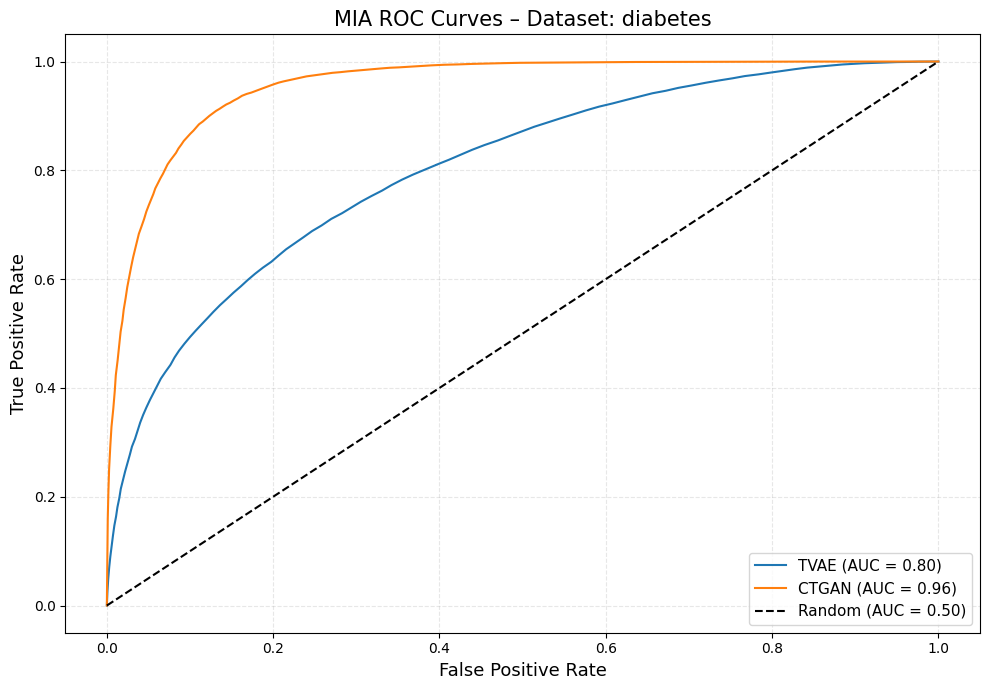


Membership Inference AUC Scores:
TVAE    : AUC = 0.801
CTGAN   : AUC = 0.955


In [8]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc

# 1. User Parameters
dataset_name = "diabetes"
generators = ["tvae", "ctgan", "ctabgan", "great", "rtf"]  
# 2. Paths
real_path = f"../data/processed/{dataset_name}_train.csv"
datasets = {}
real_df_base = pd.read_csv(real_path)
datasets["Real"] = real_df_base.copy()



plt.figure(figsize=(10, 7))
mia_scores = {}

# 3. Loop over generators
for generator_name in generators:
    synth_path = f"../data/synthetic/{generator_name}/{dataset_name}_{generator_name}.csv"
    if not os.path.exists(synth_path):
        print(f"Missing synthetic file for {generator_name}. Skipping.")
        continue

    synth_df_base = pd.read_csv(synth_path)
    
    real_df = real_df_base.copy()
    synth_df = synth_df_base.copy()
    datasets[generator_name.upper()] = synth_df_base.copy()
    
    categorical_cols = real_df.select_dtypes(include=['object', 'category']).columns.tolist()
    categorical_cols = [
        col for col in real_df.select_dtypes(include=['object', 'category']).columns
        if real_df[col].nunique() <= 20
    ]


    # --- One-hot encoding for categorical columns ---
    combined = pd.concat([real_df, synth_df], axis=0)
    encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    encoded = encoder.fit_transform(combined[categorical_cols])
    encoded_cols = encoder.get_feature_names_out(categorical_cols)

    real_encoded = pd.DataFrame(encoded[:len(real_df)], columns=encoded_cols, index=real_df.index)
    synth_encoded = pd.DataFrame(encoded[len(real_df):], columns=encoded_cols, index=synth_df.index)

    real_df = real_df.drop(columns=categorical_cols).join(real_encoded)
    synth_df = synth_df.drop(columns=categorical_cols).join(synth_encoded)

    # --- MIA labels ---
    y_member = np.ones(len(real_df))
    y_nonmember = np.zeros(len(synth_df))

    X = pd.concat([real_df, synth_df], axis=0)
    y = np.concatenate([y_member, y_nonmember])

    # --- Train/test split and attack model ---
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)

    probs = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)


    mia_scores[generator_name] = roc_auc
    plt.plot(fpr, tpr, label=f"{generator_name.upper()} (AUC = {roc_auc:.2f})")


plt.plot([0, 1], [0, 1], 'k--', label="Random (AUC = 0.50)")
plt.xlabel("False Positive Rate", fontsize=13)
plt.ylabel("True Positive Rate", fontsize=13)
plt.title(f"MIA ROC Curves – Dataset: {dataset_name}", fontsize=15)
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

# Print AUCs
print("\nMembership Inference AUC Scores:")
for model, score in mia_scores.items():
    print(f"{model.upper():8s}: AUC = {score:.3f}")


### Evaluating Number of Duplicated Within the Synthetic Dataset and between Real and Synthetic Datasets

In [9]:
# --- Run duplicate checks ---
def ensure_consistent_dtypes(datasets):
    for df in datasets.values():
        for col in df.columns:
            if df[col].dtype == 'float64' and (df[col] % 1 == 0).all():
                df[col] = df[col].astype('int64')

def count_duplicates(datasets):
    duplicate_counts = {}
    for name, df in datasets.items():
        df_rounded = df.round(6)
        duplicate_counts[name] = df_rounded.duplicated(keep=False).sum() // 2
    return duplicate_counts

def count_duplicates_with_real(datasets):
    real_data = datasets["Real"]
    duplicate_with_real = {}
    for name, df in datasets.items():
        if name != "Real":
            common_cols = df.columns.intersection(real_data.columns)
            df_copy = df[common_cols].copy()
            real_data_copy = real_data[common_cols].copy()
            df_copy = df_copy.astype(real_data_copy.dtypes)
            duplicate_with_real[name] = df_copy.merge(real_data_copy, how='inner').shape[0]
    return duplicate_with_real

ensure_consistent_dtypes(datasets)
duplicate_counts = count_duplicates(datasets)
duplicate_with_real = count_duplicates_with_real(datasets)

# --- Print results ---
print("\nNumber of duplicate rows within each dataset:")
for name, count in duplicate_counts.items():
    print(f"{name}: {count}")

print("\nNumber of duplicate rows between synthetic datasets and 'Real':")
for name, count in duplicate_with_real.items():
    print(f"{name}: {count}")



Number of duplicate rows within each dataset:
Real: 2341
TVAE: 21
CTGAN: 51

Number of duplicate rows between synthetic datasets and 'Real':
TVAE: 191
CTGAN: 19
